In [ ]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(69)
dev

tensor(0)

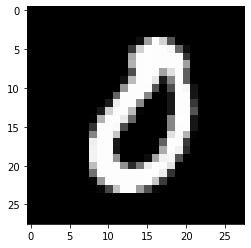

In [7]:
train_dtset = MNIST(
    root='./dataset',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])]),
    train=True
)
test_dtset = MNIST(
    root='./dataset',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])]),
    download=True,
    train=False
)
BS = 64
train_dtld = DataLoader(train_dtset, batch_size=BS, shuffle=True, drop_last=True)
test_dtld = DataLoader(test_dtset, batch_size=128, shuffle=True, drop_last=True)
a = next(iter(train_dtld))
plt.imshow(a[0][0,0], cmap='gray')
a[1][0]

In [8]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.l = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()
    def forward(self, x):
        x = self.flat(x)
        return self.l(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.res = lambda x: x.reshape((-1, 64, 7, 7))
        self.l = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.l(x)
        return x.reshape((-1, 1, 28, 28))

g = Generator().to(dev)
d = Discriminator().to(dev)
g_losses = []
d_losses = []
d(g(torch.randn((BS, 100), device=dev))).shape
# g(torch.randn((BS, 100), device=dev)).shape

torch.Size([64, 1])

In [26]:
def train_test_loop(dtld, train=True):
    g_step_losses = []
    d_step_losses = []

    for i, (x, _) in enumerate(dtld):
        x = x.to(dev)

        z = (torch.randn((BS, 100), device=dev) - .5) / .5
        ones, zeros = torch.ones((BS), device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(z)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()
        
#         g_step_losses.append(g_loss.item())
#         d_step_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

#     g_losses.append(torch.tensor(g_step_losses).mean())
#     d_losses.append(torch.tensor(d_step_losses).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

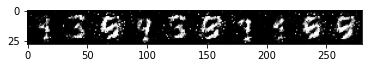

  0%|          | 1/200 [00:22<1:14:28, 22.45s/it]

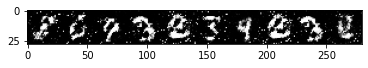

  1%|          | 2/200 [00:44<1:13:45, 22.35s/it]

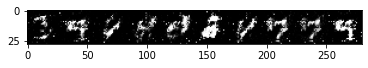

  2%|▏         | 3/200 [01:07<1:13:43, 22.45s/it]

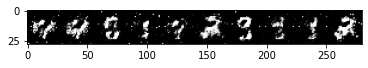

  2%|▏         | 4/200 [01:30<1:13:43, 22.57s/it]

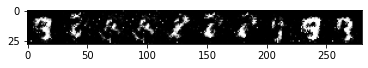

  2%|▎         | 5/200 [01:52<1:13:33, 22.63s/it]

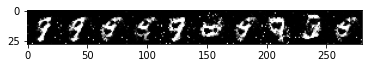

  3%|▎         | 6/200 [02:15<1:13:45, 22.81s/it]

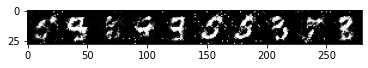

  4%|▎         | 7/200 [02:39<1:14:01, 23.01s/it]

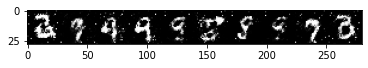

  4%|▍         | 8/200 [03:02<1:13:48, 23.06s/it]

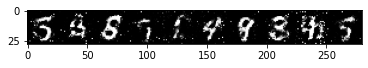

  4%|▍         | 9/200 [03:25<1:13:24, 23.06s/it]

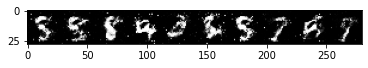

  5%|▌         | 10/200 [03:48<1:12:36, 22.93s/it]

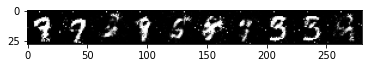

  6%|▌         | 11/200 [04:10<1:11:56, 22.84s/it]

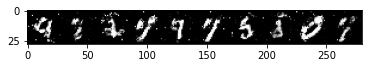

  8%|▊         | 17/200 [06:25<1:08:25, 22.43s/it]

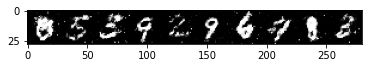

  9%|▉         | 18/200 [06:48<1:08:28, 22.58s/it]

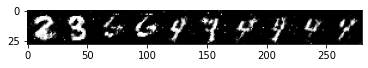

 10%|▉         | 19/200 [07:11<1:08:33, 22.73s/it]

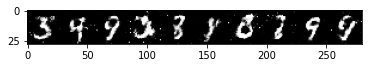

 10%|█         | 20/200 [07:33<1:08:08, 22.72s/it]

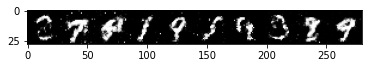

 10%|█         | 21/200 [07:56<1:07:38, 22.67s/it]

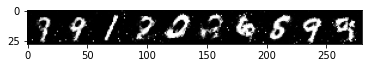

 11%|█         | 22/200 [08:19<1:07:29, 22.75s/it]

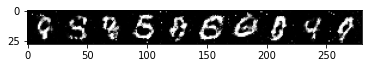

 12%|█▏        | 23/200 [08:41<1:06:57, 22.69s/it]

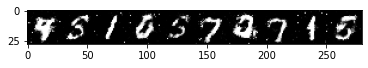

 12%|█▏        | 24/200 [09:04<1:06:26, 22.65s/it]

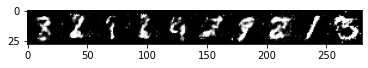

 12%|█▎        | 25/200 [09:27<1:06:08, 22.68s/it]

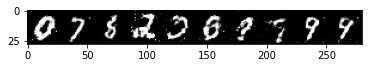

 13%|█▎        | 26/200 [09:50<1:06:08, 22.81s/it]

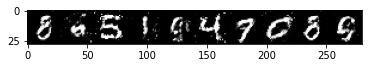

 14%|█▎        | 27/200 [10:12<1:05:30, 22.72s/it]

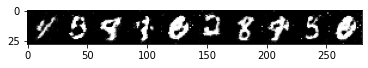

 14%|█▍        | 28/200 [10:35<1:05:09, 22.73s/it]

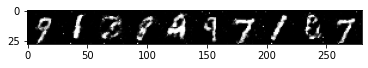

 14%|█▍        | 29/200 [10:58<1:04:34, 22.66s/it]

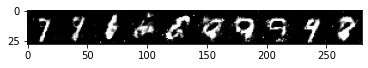

 15%|█▌        | 30/200 [11:21<1:04:34, 22.79s/it]

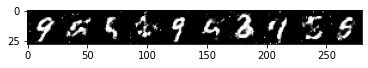

 16%|█▌        | 31/200 [11:44<1:04:19, 22.84s/it]

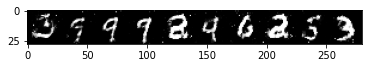

 16%|█▌        | 32/200 [12:06<1:03:54, 22.83s/it]

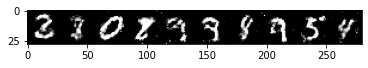

 16%|█▋        | 33/200 [12:29<1:03:39, 22.87s/it]

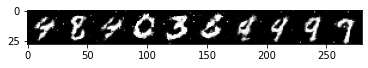

 17%|█▋        | 34/200 [12:52<1:03:14, 22.86s/it]

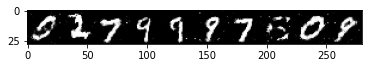

 18%|█▊        | 35/200 [13:15<1:02:34, 22.75s/it]

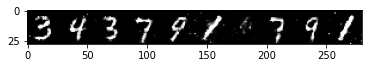

 18%|█▊        | 36/200 [13:38<1:02:19, 22.80s/it]

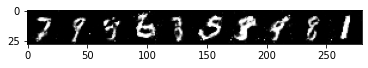

 18%|█▊        | 37/200 [14:00<1:01:51, 22.77s/it]

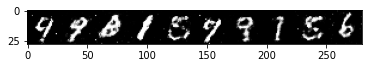

 19%|█▉        | 38/200 [14:23<1:01:13, 22.68s/it]

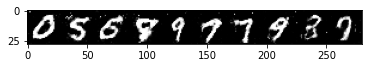

 20%|█▉        | 39/200 [14:46<1:01:01, 22.74s/it]

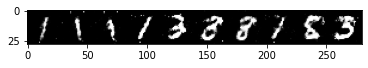

 20%|██        | 40/200 [15:08<1:00:21, 22.63s/it]

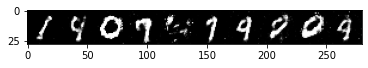

 20%|██        | 41/200 [15:30<59:34, 22.48s/it]  

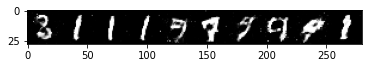

 21%|██        | 42/200 [15:53<59:28, 22.59s/it]

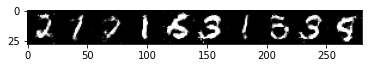

 22%|██▏       | 43/200 [16:16<59:13, 22.64s/it]

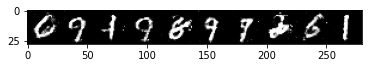

 22%|██▏       | 44/200 [16:38<58:55, 22.66s/it]

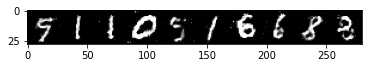

 22%|██▎       | 45/200 [17:01<58:40, 22.71s/it]

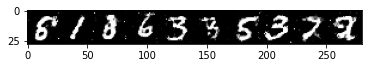

 23%|██▎       | 46/200 [17:24<58:21, 22.74s/it]

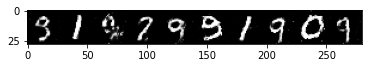

 24%|██▎       | 47/200 [17:48<58:41, 23.02s/it]

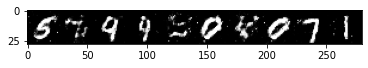

 24%|██▍       | 48/200 [18:11<58:11, 22.97s/it]

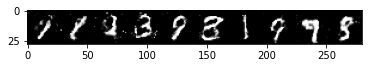

 24%|██▍       | 49/200 [18:34<57:50, 22.98s/it]

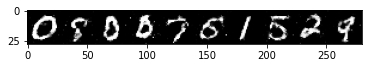

 25%|██▌       | 50/200 [18:57<57:54, 23.16s/it]

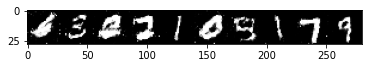

 26%|██▌       | 51/200 [19:21<57:58, 23.34s/it]

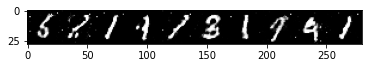

 26%|██▌       | 52/200 [19:44<57:42, 23.39s/it]

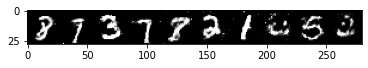

 26%|██▋       | 53/200 [20:08<57:35, 23.51s/it]

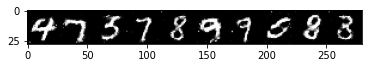

 27%|██▋       | 54/200 [20:32<57:15, 23.53s/it]

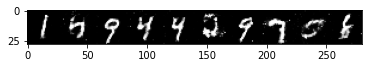

 28%|██▊       | 55/200 [20:56<57:01, 23.60s/it]

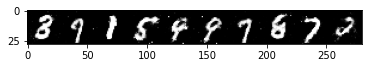

 28%|██▊       | 56/200 [21:19<56:38, 23.60s/it]

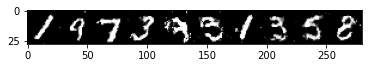

 28%|██▊       | 57/200 [21:42<55:34, 23.32s/it]

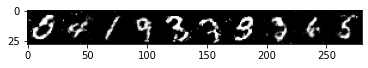

 29%|██▉       | 58/200 [22:05<55:17, 23.36s/it]

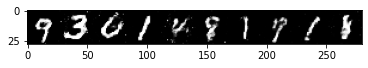

 30%|██▉       | 59/200 [22:29<54:56, 23.38s/it]

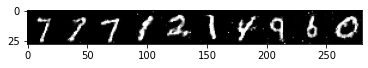

 30%|███       | 60/200 [22:52<54:43, 23.45s/it]

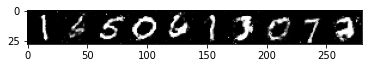

 30%|███       | 61/200 [23:16<54:16, 23.43s/it]

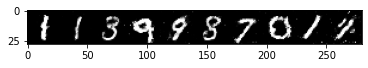

 31%|███       | 62/200 [23:39<53:31, 23.27s/it]

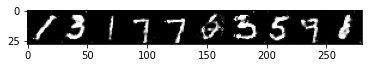

 32%|███▏      | 63/200 [24:01<52:32, 23.01s/it]

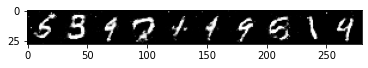

 32%|███▏      | 64/200 [24:24<52:17, 23.07s/it]

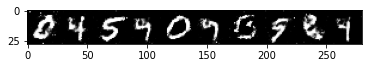

 32%|███▎      | 65/200 [24:47<51:53, 23.06s/it]

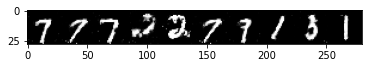

 33%|███▎      | 66/200 [25:11<51:45, 23.17s/it]

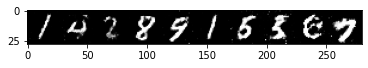

 34%|███▎      | 67/200 [25:34<51:30, 23.24s/it]

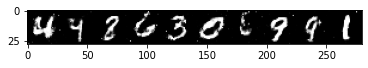

 34%|███▍      | 68/200 [25:57<50:41, 23.04s/it]

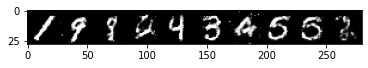

 34%|███▍      | 69/200 [26:19<50:05, 22.94s/it]

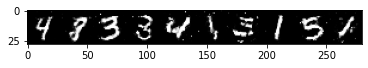

 35%|███▌      | 70/200 [26:42<49:35, 22.89s/it]

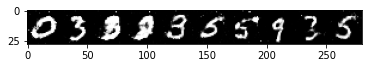

 36%|███▌      | 71/200 [27:05<49:13, 22.90s/it]

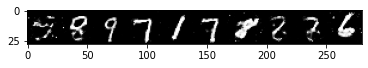

 36%|███▌      | 72/200 [27:28<48:42, 22.83s/it]

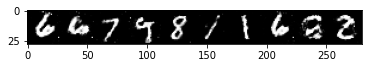

 36%|███▋      | 73/200 [27:51<48:26, 22.89s/it]

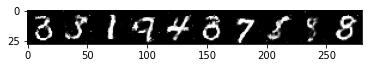

 37%|███▋      | 74/200 [28:14<48:03, 22.89s/it]

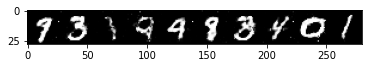

 38%|███▊      | 75/200 [28:37<47:52, 22.98s/it]

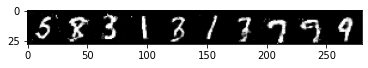

 38%|███▊      | 76/200 [29:00<47:26, 22.96s/it]

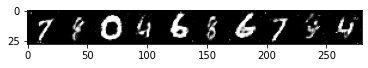

 38%|███▊      | 77/200 [29:23<47:18, 23.08s/it]

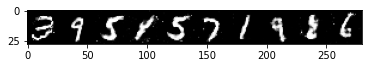

 39%|███▉      | 78/200 [29:46<46:55, 23.07s/it]

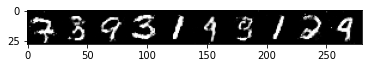

 40%|███▉      | 79/200 [30:09<46:16, 22.95s/it]

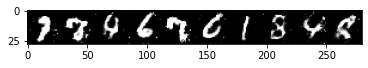

 40%|████      | 80/200 [30:32<45:48, 22.90s/it]

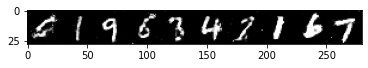

 40%|████      | 81/200 [30:55<45:30, 22.94s/it]

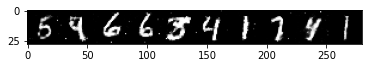

 41%|████      | 82/200 [31:18<45:22, 23.07s/it]

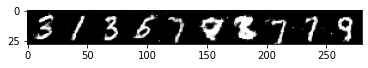

 42%|████▏     | 83/200 [31:41<44:51, 23.01s/it]

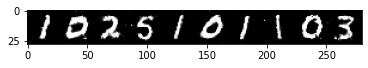

 42%|████▏     | 84/200 [32:04<44:26, 22.99s/it]

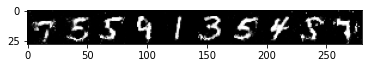

 42%|████▎     | 85/200 [32:27<43:56, 22.93s/it]

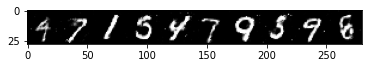

 43%|████▎     | 86/200 [32:50<43:40, 22.99s/it]

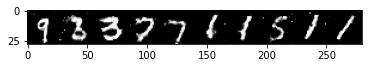

 44%|████▎     | 87/200 [33:12<43:08, 22.91s/it]

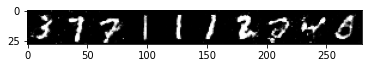

 44%|████▍     | 88/200 [33:35<42:45, 22.91s/it]

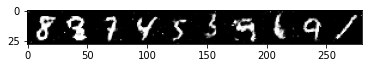

 44%|████▍     | 89/200 [33:58<42:21, 22.89s/it]

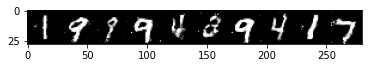

 45%|████▌     | 90/200 [34:22<42:11, 23.01s/it]

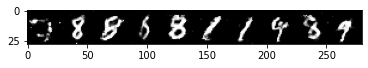

 46%|████▌     | 91/200 [34:44<41:45, 22.98s/it]

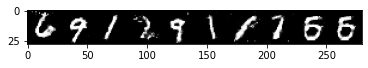

 46%|████▌     | 92/200 [35:07<41:23, 22.99s/it]

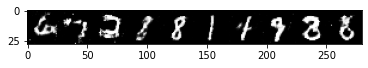

 46%|████▋     | 93/200 [35:30<40:45, 22.86s/it]

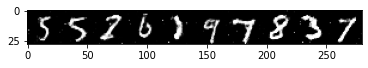

 47%|████▋     | 94/200 [35:53<40:22, 22.85s/it]

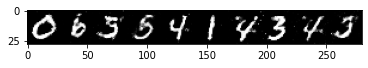

 48%|████▊     | 95/200 [36:15<39:38, 22.65s/it]

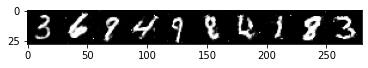

 48%|████▊     | 96/200 [36:38<39:12, 22.62s/it]

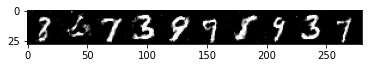

 48%|████▊     | 97/200 [37:01<39:04, 22.76s/it]

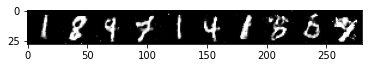

 49%|████▉     | 98/200 [37:24<38:55, 22.90s/it]

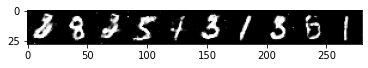

 50%|████▉     | 99/200 [37:47<38:35, 22.93s/it]

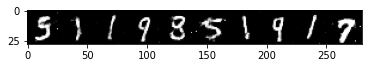

 50%|█████     | 100/200 [38:10<38:10, 22.90s/it]

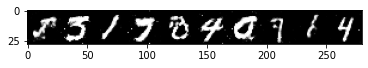

 50%|█████     | 101/200 [38:33<37:52, 22.96s/it]

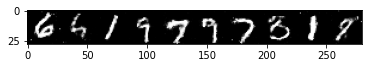

 51%|█████     | 102/200 [38:56<37:34, 23.00s/it]

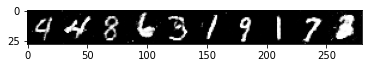

 52%|█████▏    | 103/200 [39:19<36:59, 22.88s/it]

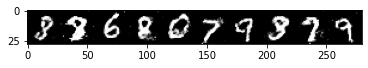

 52%|█████▏    | 104/200 [39:42<36:52, 23.05s/it]

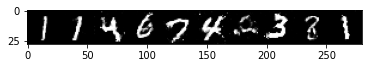

 52%|█████▎    | 105/200 [40:05<36:38, 23.14s/it]

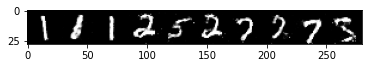

 53%|█████▎    | 106/200 [40:28<36:01, 22.99s/it]

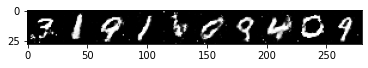

 54%|█████▎    | 107/200 [40:51<35:52, 23.14s/it]

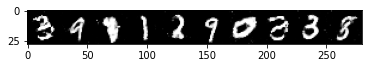

 54%|█████▍    | 108/200 [41:15<35:30, 23.16s/it]

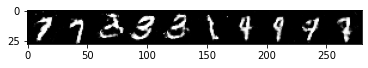

 55%|█████▍    | 109/200 [41:38<35:06, 23.14s/it]

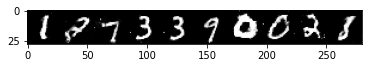

 55%|█████▌    | 110/200 [42:01<34:58, 23.31s/it]

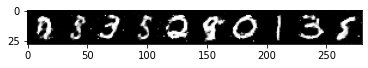

 56%|█████▌    | 111/200 [42:25<34:30, 23.26s/it]

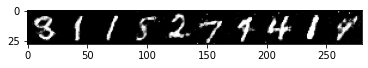

 56%|█████▌    | 112/200 [42:48<34:10, 23.30s/it]

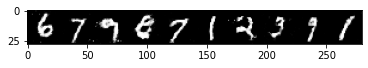

 56%|█████▋    | 113/200 [43:11<33:44, 23.27s/it]

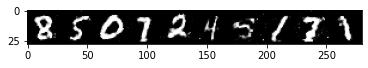

 57%|█████▋    | 114/200 [43:34<33:16, 23.22s/it]

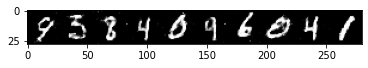

 57%|█████▊    | 115/200 [43:58<32:55, 23.24s/it]

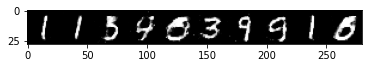

 58%|█████▊    | 116/200 [44:20<32:15, 23.04s/it]

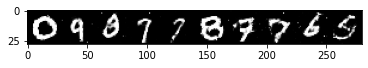

 58%|█████▊    | 117/200 [44:43<31:52, 23.04s/it]

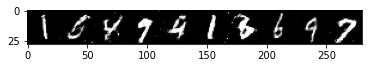

 59%|█████▉    | 118/200 [45:06<31:13, 22.84s/it]

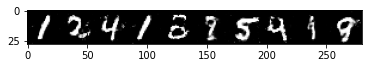

 60%|█████▉    | 119/200 [45:28<30:44, 22.77s/it]

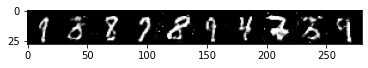

 60%|██████    | 120/200 [45:51<30:21, 22.77s/it]

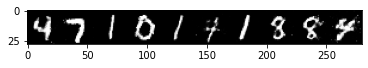

 60%|██████    | 121/200 [46:14<30:06, 22.87s/it]

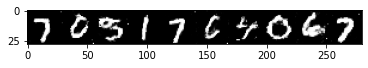

 61%|██████    | 122/200 [46:37<29:34, 22.75s/it]

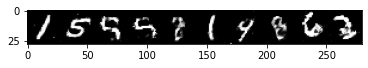

 62%|██████▏   | 123/200 [47:00<29:30, 23.00s/it]

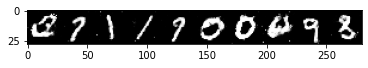

 62%|██████▏   | 124/200 [47:23<29:10, 23.03s/it]

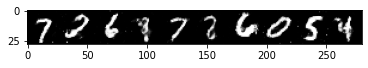

 62%|██████▎   | 125/200 [47:46<28:46, 23.02s/it]

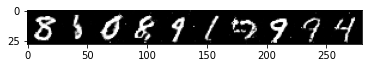

 63%|██████▎   | 126/200 [48:10<28:30, 23.12s/it]

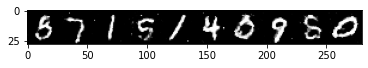

 64%|██████▎   | 127/200 [48:32<28:02, 23.05s/it]

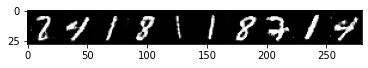

 64%|██████▍   | 128/200 [48:55<27:35, 22.99s/it]

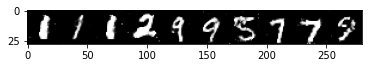

 64%|██████▍   | 129/200 [49:18<27:11, 22.98s/it]

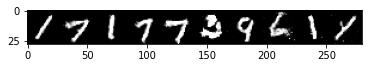

 65%|██████▌   | 130/200 [49:42<26:54, 23.06s/it]

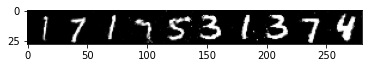

 66%|██████▌   | 131/200 [50:05<26:31, 23.06s/it]

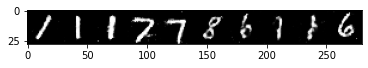

 66%|██████▌   | 132/200 [50:27<26:00, 22.95s/it]

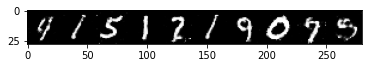

 66%|██████▋   | 133/200 [50:50<25:30, 22.84s/it]

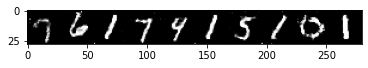

 67%|██████▋   | 134/200 [51:12<24:58, 22.70s/it]

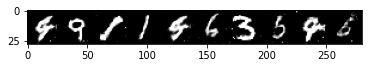

 68%|██████▊   | 135/200 [51:35<24:42, 22.81s/it]

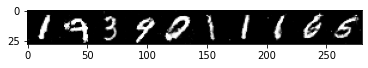

 68%|██████▊   | 136/200 [51:58<24:20, 22.82s/it]

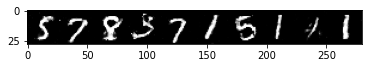

 68%|██████▊   | 137/200 [52:21<23:57, 22.82s/it]

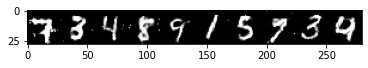

 69%|██████▉   | 138/200 [52:44<23:43, 22.96s/it]

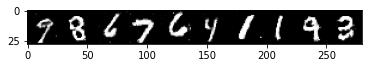

 70%|██████▉   | 139/200 [53:08<23:31, 23.14s/it]

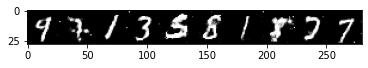

 70%|███████   | 140/200 [53:31<23:18, 23.31s/it]

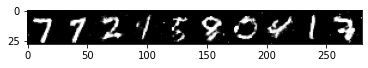

 70%|███████   | 141/200 [53:55<22:56, 23.33s/it]

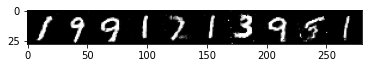

 71%|███████   | 142/200 [54:18<22:29, 23.27s/it]

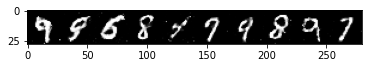

 72%|███████▏  | 143/200 [54:41<21:57, 23.12s/it]

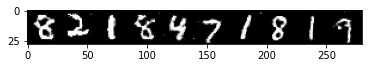

 72%|███████▏  | 144/200 [55:04<21:28, 23.01s/it]

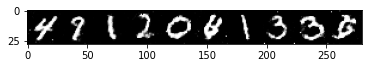

 72%|███████▎  | 145/200 [55:27<21:06, 23.03s/it]

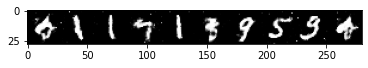

 73%|███████▎  | 146/200 [55:50<20:45, 23.07s/it]

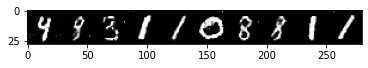

 74%|███████▎  | 147/200 [56:13<20:26, 23.14s/it]

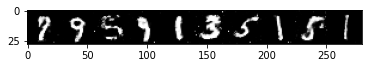

 74%|███████▍  | 148/200 [56:36<20:04, 23.16s/it]

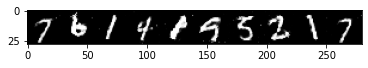

 74%|███████▍  | 149/200 [56:59<19:38, 23.11s/it]

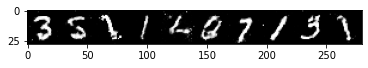

 75%|███████▌  | 150/200 [57:23<19:17, 23.15s/it]

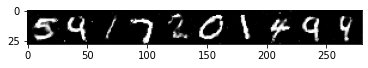

 76%|███████▌  | 151/200 [57:46<18:56, 23.19s/it]

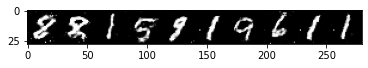

 76%|███████▌  | 152/200 [58:10<18:42, 23.39s/it]

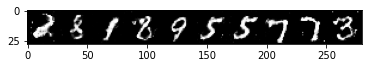

 76%|███████▋  | 153/200 [58:32<18:10, 23.19s/it]

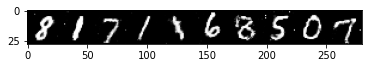

 77%|███████▋  | 154/200 [58:55<17:44, 23.15s/it]

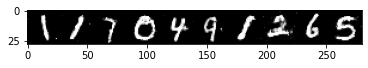

 78%|███████▊  | 155/200 [59:18<17:14, 23.00s/it]

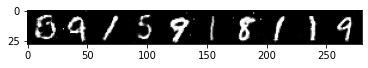

 78%|███████▊  | 156/200 [59:41<16:50, 22.96s/it]

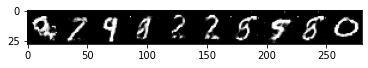

 78%|███████▊  | 157/200 [1:00:04<16:27, 22.96s/it]

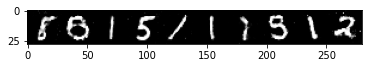

 79%|███████▉  | 158/200 [1:00:27<16:01, 22.89s/it]

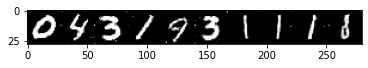

 80%|███████▉  | 159/200 [1:00:49<15:34, 22.80s/it]

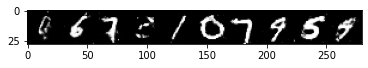

 80%|████████  | 160/200 [1:01:13<15:17, 22.94s/it]

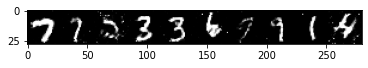

 80%|████████  | 161/200 [1:01:36<14:57, 23.02s/it]

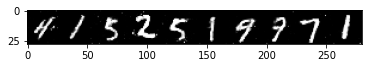

 81%|████████  | 162/200 [1:01:58<14:30, 22.90s/it]

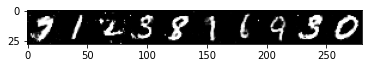

 82%|████████▏ | 163/200 [1:02:22<14:18, 23.19s/it]

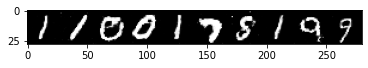

 82%|████████▏ | 164/200 [1:02:45<13:55, 23.20s/it]

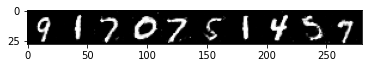

 82%|████████▎ | 165/200 [1:03:09<13:31, 23.19s/it]

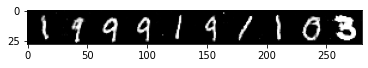

 83%|████████▎ | 166/200 [1:03:31<13:01, 22.98s/it]

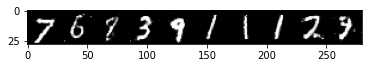

 84%|████████▎ | 167/200 [1:03:53<12:30, 22.75s/it]

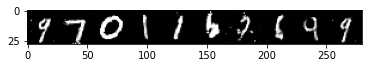

 84%|████████▍ | 168/200 [1:04:16<12:08, 22.77s/it]

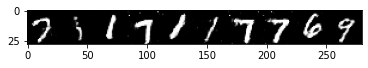

 84%|████████▍ | 169/200 [1:04:39<11:42, 22.68s/it]

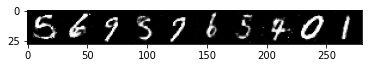

 85%|████████▌ | 170/200 [1:05:02<11:23, 22.79s/it]

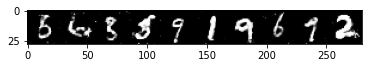

 86%|████████▌ | 171/200 [1:05:25<11:03, 22.87s/it]

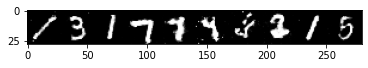

 86%|████████▌ | 172/200 [1:05:47<10:37, 22.77s/it]

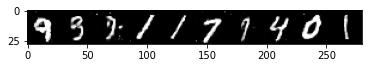

 86%|████████▋ | 173/200 [1:06:10<10:14, 22.77s/it]

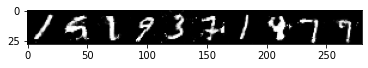

 87%|████████▋ | 174/200 [1:06:32<09:47, 22.59s/it]

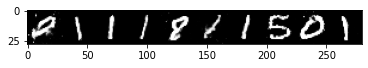

 88%|████████▊ | 175/200 [1:06:55<09:24, 22.60s/it]

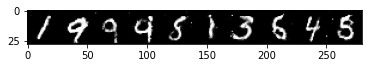

 88%|████████▊ | 176/200 [1:07:18<09:06, 22.79s/it]

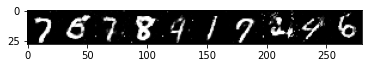

 88%|████████▊ | 177/200 [1:07:40<08:41, 22.69s/it]

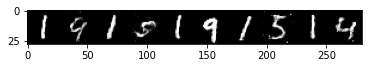

 89%|████████▉ | 178/200 [1:08:03<08:20, 22.74s/it]

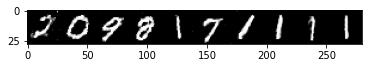

 90%|████████▉ | 179/200 [1:08:26<07:56, 22.70s/it]

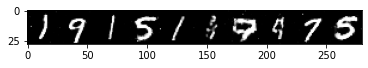

 90%|█████████ | 180/200 [1:08:48<07:33, 22.66s/it]

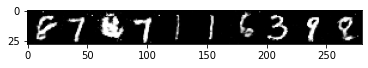

 90%|█████████ | 181/200 [1:09:11<07:09, 22.63s/it]

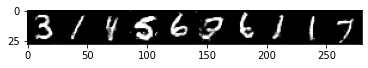

 91%|█████████ | 182/200 [1:09:33<06:46, 22.56s/it]

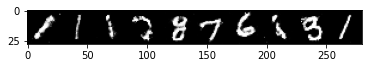

 92%|█████████▏| 183/200 [1:09:56<06:26, 22.71s/it]

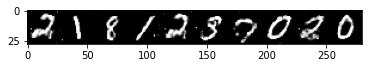

 92%|█████████▏| 184/200 [1:10:19<06:02, 22.66s/it]

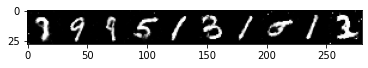

 92%|█████████▎| 185/200 [1:10:42<05:43, 22.88s/it]

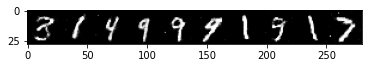

 93%|█████████▎| 186/200 [1:11:05<05:19, 22.82s/it]

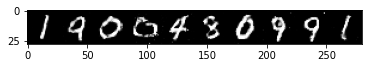

 94%|█████████▎| 187/200 [1:11:28<04:55, 22.71s/it]

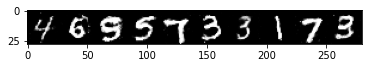

 94%|█████████▍| 188/200 [1:11:50<04:30, 22.58s/it]

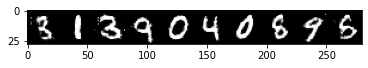

 94%|█████████▍| 189/200 [1:12:13<04:08, 22.61s/it]

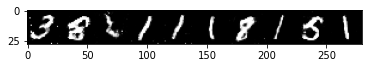

 95%|█████████▌| 190/200 [1:12:35<03:47, 22.71s/it]

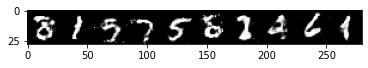

 96%|█████████▌| 191/200 [1:12:58<03:24, 22.70s/it]

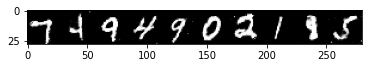

 96%|█████████▌| 192/200 [1:13:21<03:01, 22.74s/it]

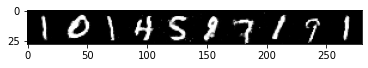

 96%|█████████▋| 193/200 [1:13:44<02:39, 22.76s/it]

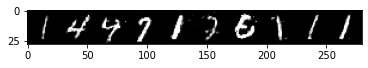

 97%|█████████▋| 194/200 [1:14:06<02:15, 22.63s/it]

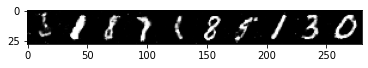

 98%|█████████▊| 195/200 [1:14:29<01:53, 22.78s/it]

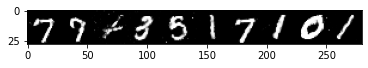

 98%|█████████▊| 196/200 [1:14:52<01:31, 22.76s/it]

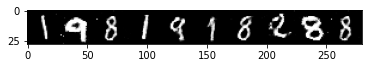

 98%|█████████▊| 197/200 [1:15:15<01:08, 22.90s/it]

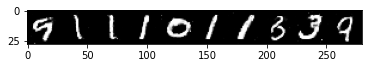

 99%|█████████▉| 198/200 [1:15:38<00:46, 23.00s/it]

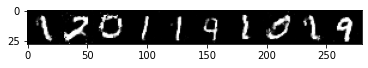

100%|█████████▉| 199/200 [1:16:01<00:22, 22.96s/it]

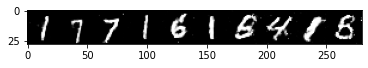

100%|██████████| 200/200 [1:16:24<00:00, 22.92s/it]


In [51]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=8e-5, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=8e-5, betas=(.5, .999))

epochs = 200

for epoch in trange(epochs):
    plt.imshow(np.concatenate(
        g((torch.randn((BS, 100), device=dev) - .5) / .5)[:10,0].cpu().detach().numpy(), axis=1), cmap='gray')
    plt.show()
    save()
    train_test_loop(train_dtld)

In [15]:
checkpoint = torch.load('checkpoint.pth')
load = False
if load:
    g.load_state_dict(checkpoint['g_state_dict'])
    d.load_state_dict(checkpoint['d_state_dict'])
    g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
    d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']

In [52]:
def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_optim_state_dict': g_optim.state_dict(),
                'd_optim_state_dict': d_optim.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, 'checkpoint.pth')
save()

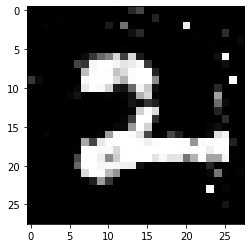

In [117]:
g.eval()
plt.subplots(1)
plt.imshow(g(torch.randn((64, 100), device=dev))[10].detach().cpu().reshape((28,28)), cmap='gray')